##### About
Text emotion detection using Decision Trees,Random Forests, Logistic regression and LSTMs.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [13]:
df = pd.read_csv('/content/drive/MyDrive/Kaggle/tweet_emotions.csv')

In [14]:
df

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
...,...,...,...
39995,1753918954,neutral,@JohnLloydTaylor
39996,1753919001,love,Happy Mothers Day All my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [15]:
# removing empty sentiment
pruned_df = df[df['sentiment']!='empty']
pruned_df

,tweet_id,sentiment,content
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
5,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to...
...,...,...,...
39995,1753918954,neutral,@JohnLloydTaylor
39996,1753919001,love,Happy Mothers Day All my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [16]:
pruned_df.describe

<bound method NDFrame.describe of          tweet_id   sentiment  \
1      1956967666     sadness   
2      1956967696     sadness   
3      1956967789  enthusiasm   
4      1956968416     neutral   
5      1956968477       worry   
...           ...         ...   
39995  1753918954     neutral   
39996  1753919001        love   
39997  1753919005        love   
39998  1753919043   happiness   
39999  1753919049        love   

                                                 content  
1      Layin n bed with a headache  ughhhh...waitin o...  
2                    Funeral ceremony...gloomy friday...  
3                   wants to hang out with friends SOON!  
4      @dannycastillo We want to trade with someone w...  
5      Re-pinging @ghostridah14: why didn't you go to...  
...                                                  ...  
39995                                   @JohnLloydTaylor  
39996                     Happy Mothers Day  All my love  
39997  Happy Mother's Day to all the m

In [17]:
#checking null values
pruned_df.isnull().sum()

tweet_id     0
sentiment    0
content      0
dtype: int64

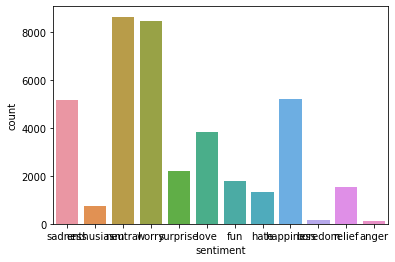

In [18]:
# let's have a look at the distribution of data across various sentiments.
sns.countplot(x ='sentiment', data = pruned_df)


Remarks - The number of samples per sentiment is non-uniform. If the samples/sentiment would have been uniform, We could have expected a better accuracy. 

In [19]:
#checking for duplicated values
pruned_df.duplicated().sum()

0

#### Cleaning dataframe's text i.e content column


In [20]:

#functions for cleaning
#1. Lemmatisation 
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]
    
    return " " .join(text)



In [21]:
#2. Remove stopwords
def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

In [22]:
#3. Remove numbers
def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

In [23]:
#4. lower case
def lower_case(text):
    
    text = text.split()

    text=[y.lower() for y in text]
    
    return " " .join(text)

In [24]:
# 5. Remove punctuations
def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

In [25]:
#6. Remove urls
def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [26]:
def normalize_text(df):
    df.content=df.content.apply(lambda text : lower_case(text))
    df.content=df.content.apply(lambda text : remove_stop_words(text))
    df.content=df.content.apply(lambda text : Removing_numbers(text))
    df.content=df.content.apply(lambda text : Removing_punctuations(text))
    df.content=df.content.apply(lambda text : Removing_urls(text))
    df.content=df.content.apply(lambda text : lemmatization(text))
    return df

In [27]:
pruned_df= normalize_text(pruned_df)


/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [28]:
pruned_df

,tweet_id,sentiment,content
1,1956967666,sadness,layin n bed headache ughhhh waitin call
2,1956967696,sadness,funeral ceremony gloomy friday
3,1956967789,enthusiasm,want hang friend soon
4,1956968416,neutral,dannycastillo want trade someone houston ticke...
5,1956968477,worry,re pinging ghostridah go prom bc bf like friend
...,...,...,...
39995,1753918954,neutral,johnlloydtaylor
39996,1753919001,love,happy mother day love
39997,1753919005,love,happy mother s day mommy there woman man long ...
39998,1753919043,happiness,niariley wassup beautiful follow me peep new h...


In [29]:
# uncomment to use bag of words features, we shall use TFIDF
# #creating bag of words model
# from sklearn.feature_extraction.text import CountVectorizer
# cv = CountVectorizer(max_features=5000)
# X = cv.fit_transform(pruned_df.content).toarray()
# y = pruned_df.sentiment.values

In [30]:
X = pruned_df['content'].values
y = pruned_df['sentiment'].values

In [31]:
# splitting into train and test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=0)

In [32]:
print("Shape of X_train",X_train.shape)
print("Shape of X test",X_test.shape)

Shape of X_train (33297,)
Shape of X test (5876,)


In [33]:
# # fitting different models
# svc_classifier = SVC() #it will take time #kernel='rbf', random_state=1, gamma=0.1, C=0.02

# svc_classifier.fit(X_train,y_train)
# # takes too much time, Hours

In [65]:
# training decision tree
decision_tree = Pipeline([('vect',TfidfVectorizer()),
                         ('clf', DecisionTreeClassifier(random_state = 0))])
        

In [66]:
decision_tree.fit(X_train,y_train)

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', DecisionTreeClassifier(random_state=0))])

In [67]:
y_pred=decision_tree.predict(X_test)


In [68]:
decision_tree_accuracy = accuracy_score(y_test, y_pred)
print("The accuracy of Decision tree is {}".format(decision_tree_accuracy))


The accuracy of Decision tree is 0.2704220558202859


In [69]:
# f1 score
decision_tree_f1=f1_score(y_test,y_pred, average=None)
pd.DataFrame(decision_tree_f1, index=pruned_df.sentiment.unique(), columns=['F1 score']) 



,F1 score
sadness,0.000000
enthusiasm,0.000000
neutral,0.010526
worry,0.084706
surprise,0.246210
love,0.237569
fun,0.337640
hate,0.354975
happiness,0.080214
boredom,0.241077


In [70]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        16
     boredom       0.00      0.00      0.00        28
  enthusiasm       0.01      0.01      0.01       120
         fun       0.11      0.07      0.08       266
   happiness       0.23      0.26      0.25       777
        hate       0.29      0.20      0.24       213
        love       0.34      0.34      0.34       581
     neutral       0.33      0.39      0.35      1291
      relief       0.11      0.06      0.08       234
     sadness       0.26      0.22      0.24       803
    surprise       0.08      0.05      0.06       324
       worry       0.28      0.34      0.31      1223

    accuracy                           0.27      5876
   macro avg       0.17      0.16      0.16      5876
weighted avg       0.26      0.27      0.26      5876



In [71]:
# training random forests
random_forests = Pipeline([('vect',TfidfVectorizer()),
                         ('clf', RandomForestClassifier(random_state = 0))])

In [72]:
random_forests.fit(X_train,y_train)

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', RandomForestClassifier(random_state=0))])

In [73]:
y_pred=random_forests.predict(X_test)

In [74]:
random_forests_accuracy = accuracy_score(y_test, y_pred)
print("The accuracy of Random forests is {}".format(random_forests_accuracy))

The accuracy of Random forests is 0.3407079646017699


In [75]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        16
     boredom       0.00      0.00      0.00        28
  enthusiasm       0.00      0.00      0.00       120
         fun       0.16      0.02      0.03       266
   happiness       0.31      0.30      0.31       777
        hate       0.40      0.16      0.23       213
        love       0.47      0.40      0.43       581
     neutral       0.34      0.60      0.43      1291
      relief       0.31      0.06      0.09       234
     sadness       0.37      0.20      0.26       803
    surprise       0.22      0.04      0.06       324
       worry       0.32      0.44      0.37      1223

    accuracy                           0.34      5876
   macro avg       0.24      0.18      0.19      5876
weighted avg       0.33      0.34      0.31      5876



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
# training logistic regression
log_reg = Pipeline([('vect',TfidfVectorizer()),
                         ('clf', LogisticRegression(solver='liblinear',random_state = 0))])

In [77]:
log_reg.fit(X_train,y_train)

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf',
                 LogisticRegression(random_state=0, solver='liblinear'))])

In [78]:
y_pred=log_reg.predict(X_test)

In [79]:
log_reg_accuracy = accuracy_score(y_test, y_pred)
print("The accuracy of Logistic Regression is {}".format(log_reg_accuracy))

The accuracy of Logistic Regression is 0.3563648740639891


#### Next Step
Let's train LSTM.

In [34]:
train_content = pruned_df['content']
train_sentiment = pruned_df['sentiment']

In [35]:
# splitting into train and test
X_train,X_test,y_train,y_test = train_test_split(train_content,train_sentiment,test_size=0.15,random_state=0)

In [36]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


In [37]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [38]:
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

In [39]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [40]:
maxlen = max([len(t) for t in X_train])
print(maxlen)


133


In [41]:
#padding sequences
X_train = pad_sequences(sequences_train, maxlen=maxlen, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=maxlen, truncating='pre')

In [42]:
vocabSize = len(tokenizer.index_word) + 1


In [43]:
vocabSize

42734

In [44]:
#before padding
sequences_train[0]


[492, 13459, 1284, 69, 8, 13460]

In [45]:
# after padding
X_train[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,   492,

In [46]:
#reading glove embeddings
path_to_glove_file = '/content/drive/MyDrive/Kaggle/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200 #latent factors or features  
hits = 0
misses = 0
embeddings_index = {}

In [47]:
# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 20060 words (22673 misses)


In [48]:
pip install -U numpy==1.18.5


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 76.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2022.12.0 requires numpy>=1.20, but you have numpy 1.18.5 which is incompatible.
xarray-einstats 0.4.0 requires numpy>=1.20, but you have numpy 1.18.5 which is incompatible.
tifffile 2022.10.10 requires numpy>=1.19.2, but you have numpy 1.18.5 which is incompatible.
tensorflow 2.9.2 requires numpy>=1.20, but you have numpy 1.18.5 which is incompatible.
tables 3.7.0 requires numpy>=1.19.0, but you have numpy 1.18.5 which is incompatible.
plotnine 0.8.0 requires numpy>=1.19.0, but you

In [49]:
adam = Adam(learning_rate=0.01)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(512, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(12, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 133, 200)          8546800   
                                                                 
 bidirectional (Bidirectiona  (None, 133, 1024)        2920448   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 133, 512)         2623488   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              656384    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 12)                3084      
                                                        

In [50]:
callback = EarlyStopping(
   monitor="val_loss",
   patience=4,
   restore_best_weights=True,
)

In [54]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    verbose=1,
                    batch_size=256,
                    validation_data=(X_test, y_test),
                    callbacks=[callback],
                    epochs=10,
                   )

Epoch 1/10
131/131 [==============================] - 463s 4s/step - loss: 2.0903 - accuracy: 0.2362 - val_loss: 2.0921 - val_accuracy: 0.2423
Epoch 2/10
131/131 [==============================] - 458s 3s/step - loss: 2.0463 - accuracy: 0.2596 - val_loss: 2.0674 - val_accuracy: 0.2657
Epoch 3/10
131/131 [==============================] - 456s 3s/step - loss: 1.9722 - accuracy: 0.3032 - val_loss: 1.9736 - val_accuracy: 0.3142
Epoch 4/10
131/131 [==============================] - 454s 3s/step - loss: 1.9278 - accuracy: 0.3251 - val_loss: 1.9810 - val_accuracy: 0.3019
Epoch 5/10
131/131 [==============================] - 453s 3s/step - loss: 1.9031 - accuracy: 0.3373 - val_loss: 1.9128 - val_accuracy: 0.3332
Epoch 6/10
131/131 [==============================] - 450s 3s/step - loss: 1.8800 - accuracy: 0.3433 - val_loss: 1.9259 - val_accuracy: 0.3320
Epoch 7/10
131/131 [==============================] - 449s 3s/step - loss: 1.8744 - accuracy: 0.3471 - val_loss: 1.9762 - val_accuracy: 0.3111

In [55]:
model.evaluate(X_test, y_test, verbose=1) 



184/184 [==============================] - 58s 314ms/step - loss: 1.9128 - accuracy: 0.3332


[1.912813663482666, 0.33321988582611084]

In [63]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt


epochs = range(len(history.history['accuracy']))





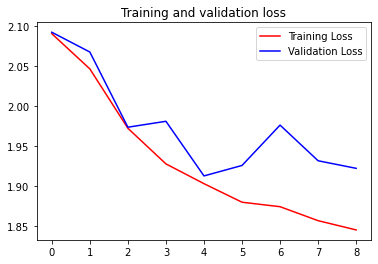

In [64]:
plt.plot(epochs, history.history['loss'], 'r', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<Figure size 432x288 with 0 Axes>

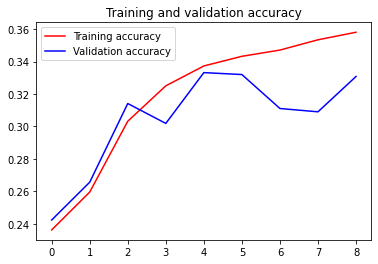

<Figure size 432x288 with 0 Axes>

In [65]:
plt.plot(epochs, history.history['accuracy'], 'r', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [66]:
#saving model
model.save('Model.h5')

In [67]:
def cleaned_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence

In [68]:
sentence= 'Wow, This seems like an exciting result!'
sentence = cleaned_sentence(sentence)
sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
proba =  np.max(model.predict(sentence))
print(result,proba)

1/1 [==============================] - 0s 465ms/step
happiness 0.30866018
